# Kazakhstan Vehicles Data Ad-Hoc Analysis

#### Analysis By: Quek Hong Rui

# Introduction

This ad-hoc analysis project investigates vehicles in Kazakhstan. It uses a data set of **10,885** vehicles which contains information like the vehicle driver's particulars, vehicle details, insurance period and premium as well as road accident details, if any. This project aims to answer specific questions related to the data through data manipulation *(eg filtering, aggregation, sorting operations)*, so as to synthesise findings that might be of interest to business stakeholders. 

This project uses the **pandas** and **NumPy** libraries for data manipulation; and **Matplotlib Pyplot** and **Seaborn** for some data visualization.

This project was inspired by a [Kaggle project](https://www.kaggle.com/datasets/nenriki/kz-insurance-company/data) on the same topic. The business questions used in the Kaggle project have also been recycled and adapted for this project. 

The original data set `Dataset_pandas_assign.xlsx` *(attached in the aforementioned Kaggle project)* is in Russian, so an external [online document translator](https://www.onlinedoctranslator.com/en/) was used to translate the data set to English. The translated data set `Dataset_pandas_assign_translated.xlsx`, which is enclosed in the folder storing this Jupyter Notebook, will be used for this analysis.

In [1]:
## Importing libraries and data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import datetime

df = pd.read_excel("Dataset_pandas_assign_translated.xlsx")
df

,Unique number,"Age, completed years",Citizenship,Driving experience,Floor,KBM,City,Brand,Model,Vehicle type,Year of issue,Steering wheel position,Engine capacity,Color,Insurance period,Insurance premium,Privileges,Date of incident,Region of accident,Amount of loss
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,18,19,23,25,26.0
1,74d88aec9cfe39a1bc5a93314c4326dc,30,Kazakhstan,10,M,8,Almaty,156,Alfa Romeo,Cars,2000-12-01 00:00:00,Left,3000,red,06/14/2013-06/13/2014,17625,NaN,NaN,NaN,NaN
2,c13fe1fef2192e82056e26544c3efed3,36,Kazakhstan,17,M,8,Nur-Sultan,156,Alfa Romeo,Cars,2001-12-01 00:00:00,Left,2387,blue,07/19/2013-07/18/2014,8484,NaN,NaN,NaN,NaN
3,8dd751c0f9c0cf216303a0d445099e1b,46,Kazakhstan,28,M,8,Almaty,Rsv 1000r,Aprilia,Motorcycles and scooters,2005-12-01 00:00:00,Left,998,red,06/07/2013-06/06/2014,8031,NaN,NaN,NaN,NaN
4,005f21aeed2db9c1694f724f365be6b5,45,Kazakhstan,13,M,7,Nur-Sultan,80,Audi,Cars,1992-12-01 00:00:00,Left,1984,archival silver metallic,05/30/2013-11/29/2013,6709,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10905,c6a3b53d633ff4155492e2e19b9a8010,57,Kazakhstan,35,M,8,Pavlodar,Niva 212300-55,Chevrolet,Cars,2012-12-01 00:00:00,Left,1690,metallic gray,06/12/2013-04/10/2014,6976,NaN,NaN,NaN,NaN
10906,c84892e816bec0dbd5429c75fb57b305,55,Kazakhstan,20,M,9,Petropavlovsk,Niva 212300-55I,Chevrolet,Cars,2012-01-01 00:00:00,Left,1690,silver,06/16/2013-06/15/2014,6400,NaN,NaN,NaN,NaN
10907,d406878650cbf18002d29968bf832c31,73,Kazakhstan,45,M,8,Kostanay,Niva 212300-55I,Chevrolet,Cars,2010-12-01 00:00:00,Left,1700,The Snow Queen,06/18/2013-06/17/2014,10053,NaN,NaN,NaN,NaN
10908,dcb07973b07a508c4680406b38fdfa56,67,Kazakhstan,20,M,8,Ust-Kamenogorsk,Niva 212300-55glc,Chevrolet,Cars,2011-12-01 00:00:00,Left,1690,The Snow Queen,07/01/2013-06/30/2014,5052,Disabled person,NaN,NaN,NaN


# Data Preparation

Due to gaps in translation and data issues in the original data set, some parts of the data set need to be manually changed for logically sound and higher quality data.

1. The first row in the data set which are the columns' numeric indices will be removed as it does not represent actual column values. 

In [2]:
df = df.drop(0, axis = "index")

2. For clarity of column names, the `Floor`, `KBM` and `Year of issue` columns will be renamed as `Gender`, `Bonus-Malus Class` and `Date Of Manufacture`. Additionally, the names of the `Brand` and `Model` columns need to be swapped as the column names do not match the data values. For style preferences, the other column names will be converted to title case too. 

In [3]:
df = df.rename(columns = {"Floor": "Gender", 
                          "KBM": "Bonus-Malus Class", 
                          "Year of issue": "Date Of Manufacture", 
                          "Brand": "Model", 
                          "Model": "Brand"})
df.columns = map(lambda x: x.title(), df.columns)

3. The **M** and **AND** values in the `Gender` column and the **On right** values in the `Steering Wheel Position` column will be replaced with **Male**, **Female** and **Right** respectively for more intuitive category names.

In [4]:
df["Gender"] = df["Gender"].replace({"M": "Male", "AND": "Female"})
df["Steering Wheel Position"] = df["Steering Wheel Position"].replace("On right", "Right")

4. Duplicate rows in the data set will be removed.

In [5]:
df = df.drop_duplicates()

5. Some of the following questions involve the `City` data column. However, many of the values in the column are not clean. 

- Some of the stated cities are repetitions of a substring *eg* **Nur-Sultan, Nur-Sultan** which should be collapsed to the **Nur-Sultan** category. 
- Some of the stated cities have unnecessary or meaningless suffixes *eg* **s.o.**, **p.a.**, **village**.
- Some of the stated cities are unintelligible or are not actual cities *eg* **Rabbitfarm**, **International**, **Watermelon**.

The following code chunk removes these issues from the `City` column. The remaining erroneous city labels will be replaced through hard-coding.

In [6]:
def test(string):
    errors = [",", " ", ".", "-", ## remove these too as they cause re.findall() to trip
              "s.o.", "p.a.", "a.o.", "S.O.", "city", "district", "village"] ## remove unnecessary suffixes
    for error in errors:
        string = string.replace(error, "")
    res = re.findall(r'^(\w+?)\1*$', string)[0] ## Find root substring of repeated substring
    return res

df["City"] = df.apply(lambda x: test(x["City"]), axis = 1)

## Not actual cities

replace_lst = ["Beautiful", "Coastal", "Corners", "Cup", "Elevation", "Families", "Free", "Garden", "Geologist",
               "Granite", "International", "Kazakh", "Motherland", "Obese", "Ore", "Progress", "Rabbitfarm", "River",
               "Temporaryregistration", "Trade", "Watermelon", "Wide", "Youth"]

## Replacement by manual hard-coding

city_replace_dict = {"AktobeAktau": "Aktau", 
                "AlmatyOtegenbatyr": "Otegen Batyr", 
                "AlmatyShymkent": "Shymkent", 
                "AlmatyTausamaly": "Tausamaly", 
                "AlmatyTuzdybastau": "Tuzdybastau", 
                "BeisaHazireta": "Beisa Hazireta", 
                "BelagashskyZhaksyBelagash": "Belagashsky", 
                "Belovodskoe": "Belovodskoye", 
                "BMomyshuly": "B.Momyshuly", 
                "BukharZhyrau": "Bukhar-Zhyrau",
                "ChapaevoChapayevo": "Chapaevo", 
                "DvurechnoeDvurechnoye": "Dvurechnoe", 
                "FreeYesil": "Yesil", 
                "Ishimskoe": "Ishimskoye", 
                "Kabanbaibatyr": "Kabanbai Batyr", 
                "KishiBeiserke": "Kishi Beiserke", 
                "KosshyNurSultan": "Kosshy", 
                "KrasnayaPolyana": "Krasnaya Polyana", 
                "KrasnyYar": "Krasny Yar", 
                "MalayaChurakovka": "Malaya Churakovka", 
                "MukhametzhanTuimebaeva": "Mukhametzhan Tuimebaeva", 
                "Nauryzbaybatyr": "Nauryzbay Batyr", 
                "Novomarinivka": "Novomarinovka", 
                "NurSultan": "Nur-Sultan", 
                "NurSultanAtbasar": "Atbasar", 
                "ShymkentAlmaty": "Shymkent", 
                "UstKamenogorsk": "Ust-Kamenogorsk", 
                "UstTalovka": "Ust-Talovka", 
                "VerkhUba": "Verkh-Uba", 
                "YesilKalachi": "Kalachi", 
                "Yesilskyforestryenterprise": "Yesilsky", 
                "YesilZarechnoye": "Zarechnoye", 
                "Kaskelenskaya": "Kaskelen", 
                "ZhibekZholy": "Zhibek Zholy", 
                "Zhapekbatyr": "Zhapek Batyr", 
                "Otegenbatyr": "Otegen Batyr", 
                "Belgorodskoe": "Belgorodsky",
                "Pavlodarskoe": "Pavlodar", 
                "Razdolnoe": "Razdolnoye", 
                "Talgarskaya": "Talgar", 
                "Zatobolskaya": "Zatobolsk", 
                "ZhanaKiima": "Zhana Kiyma", 
                "ZhanaKiyma": "Zhana Kiyma"}

df["City"] = df["City"].replace(city_replace_dict)
df["City"] = df["City"].replace(replace_lst, "Others")

6. Question 6 below involves grouping the `Color` column values to **Dark** or **Light**. The car colors in the data set will be categorized as dark and light with reference to this [online color guide](https://pages.mtu.edu/~nilufer/classes/cs3611/interesting-stuff/designing-with-colors-1/color_contrast.htm). In addition, white is categorized as **Light** while black, gray and brown are categorized as **Dark**.
<br><br>
All shades or hues of a particular color will be mapped to the color group of that color. For instance, light blue will be mapped to **Dark** since blue is considered a **Dark** color. 
<br><br>
The remaining colors will be mapped to their color groups manually.

In [7]:
df["Color"] = df["Color"].astype(str).str.lower()

light_colors = ["green", "yellow", "orange", "white"]
dark_colors = ["black", "red", "brown", "gray", "grey", "purple", "violet", "blue"]

## If color label contains any of the colors in light_colors (dark_colors), it will be grouped as Light (Dark)

light_condition = df["Color"].str.contains("|".join(light_colors), regex = True) & ~df["Color"].str.contains("|".join(dark_colors), regex = True)
dark_condition = df["Color"].str.contains("|".join(dark_colors), regex = True) & ~df["Color"].str.contains("|".join(light_colors), regex = True)

## Manually grouping remaining colors 

color_replace_dict = {'archival silver metallic' : "Dark", 
                      'dark cherry': "Dark", 
                      'silver': "Dark",
                      'cherry metallic': "Dark", 
                      'wet asphalt': "Dark", 
                      'burgundy': "Dark",
                      'dark burgundy metallic': "Dark", 
                      'beige': "Light", 
                      'burgundy metallic': "Dark", 
                      'cherry': "Dark",
                      'golden metallic': "Light", 
                      'golden': "Light", 
                      'ripe cherry': "Dark", 
                      'silver metallic': "Dark",
                      'steel': "Dark", 
                      'dark burgundy': "Dark", 
                      'ruby': "Dark", 
                      'pink metallic': "Dark",
                      'grey-green metallic': "Dark", 
                      'gray-white': "Dark", 
                      'lilac metallic': "Light", 
                      'combined': "Dark",
                      'grey-green archival': "Dark", 
                      'beige metallic': "Light", 
                      'crimson': "Dark", 
                      'silver-pearl': "Dark",
                      'blue-green metallic': "Dark", 
                      'white-blue': "Dark", 
                      'grey-green pearlescent': "Dark",
                      'turquoise': "Dark", 
                      'white-gray': "Dark", 
                      'olive': "Dark", 
                      'bronze': "Dark", 
                      'bronze metallic': "Dark",
                      'space': "Light", 
                      'the snow queen': "Light", 
                      'gray-green': "Dark", 
                      'blue-green': "Dark", 
                      'sand': "Light",
                      'light beige': "Light", 
                      'cherry pearlescent': "Dark", 
                      'graphite': "Dark", 
                      'pearl': "Light", 
                      'metal': "Dark",
                      'pomegranate': "Dark", 
                      'apricot': "Light", 
                      'lilac': "Light", 
                      'dark beige archival': "Dark", 
                      'khaki': "Light",
                      'gray with a green tint metallic': "Dark", 
                      'green-blue': "Dark", 
                      'ashen': "Dark",
                      'pink pearlescent': "Dark", 
                      'blue-green pearlescent': "Light", 
                      'blue-white': "Dark",
                      'light smoky': "Dark", 
                      'safari': "Dark", 
                      'graphite metallic': "Dark", 
                      'corida': "Dark", 
                      'ivory': "Light",
                      'emerald': "Dark", 
                      'coffee': "Dark", 
                      'sea \u200b\u200bwave': "Dark", 
                      'valentine': "Dark",
                      'gold ocher': "Light", 
                      'lotus': "Dark", 
                      'the golden fleece': "Light", 
                      'light lilac metallic': "Light",
                      'primrose': "Light", 
                      'papyrus': "Light", 
                      'black with green metallic tint': "Dark",
                      'light silver metallic': "Dark", 
                      'smoky': "Dark", 
                      'iceberg': "Light", 
                      'gobi': "Light", 
                      'gray-yellow': "Dark",
                      'liana': "Dark", 
                      'coral': "Dark", 
                      'tavria': "Dark", 
                      'senezh': "Dark", 
                      'adriatic': "Dark", 
                      'cyclone': "Dark",
                      'cypress': "Dark", 
                      'pitsunda': "Dark", 
                      'citric': "Light"}

df["Color Group"] = np.where(light_condition, "Light", np.where(dark_condition, "Dark", df["Color"]))
df["Color Group"] = df["Color Group"].replace(color_replace_dict)

7. Some of the following questions require knowledge on which observations or rows in the data set correspond to vehicles involved in a road accident. This analysis will consider observations with missing `Date Of Incident` and `Region Of Accident` values as **Non-Accidents**, while those with `Date Of Incident` and `Region Of Accident` values are **Accidents**.

In [8]:
df["Accident Status"] = np.where((~df["Date Of Incident"].isna()) & (~df["Region Of Accident"].isna()), "Accident", "Non-Accident")

After the modifications, the data set now looks like this: 

In [9]:
df

,Unique Number,"Age, Completed Years",Citizenship,Driving Experience,Gender,Bonus-Malus Class,City,Model,Brand,Vehicle Type,...,Engine Capacity,Color,Insurance Period,Insurance Premium,Privileges,Date Of Incident,Region Of Accident,Amount Of Loss,Color Group,Accident Status
1,74d88aec9cfe39a1bc5a93314c4326dc,30,Kazakhstan,10,Male,8,Almaty,156,Alfa Romeo,Cars,...,3000,red,06/14/2013-06/13/2014,17625,NaN,NaN,NaN,NaN,Dark,Non-Accident
2,c13fe1fef2192e82056e26544c3efed3,36,Kazakhstan,17,Male,8,Nur-Sultan,156,Alfa Romeo,Cars,...,2387,blue,07/19/2013-07/18/2014,8484,NaN,NaN,NaN,NaN,Dark,Non-Accident
3,8dd751c0f9c0cf216303a0d445099e1b,46,Kazakhstan,28,Male,8,Almaty,Rsv 1000r,Aprilia,Motorcycles and scooters,...,998,red,06/07/2013-06/06/2014,8031,NaN,NaN,NaN,NaN,Dark,Non-Accident
4,005f21aeed2db9c1694f724f365be6b5,45,Kazakhstan,13,Male,7,Nur-Sultan,80,Audi,Cars,...,1984,archival silver metallic,05/30/2013-11/29/2013,6709,NaN,NaN,NaN,NaN,Dark,Non-Accident
5,00a216cee7321c4514ecbe9cbd97a4eb,48,Kazakhstan,18,Male,9,Zatobolsk,C4,Audi,Cars,...,2800,metallic gray,05/28/2013-05/27/2014,8257,NaN,NaN,NaN,NaN,Dark,Non-Accident
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10905,c6a3b53d633ff4155492e2e19b9a8010,57,Kazakhstan,35,Male,8,Pavlodar,Niva 212300-55,Chevrolet,Cars,...,1690,metallic gray,06/12/2013-04/10/2014,6976,NaN,NaN,NaN,NaN,Dark,Non-Accident
10906,c84892e816bec0dbd5429c75fb57b305,55,Kazakhstan,20,Male,9,Petropavlovsk,Niva 212300-55I,Chevrolet,Cars,...,1690,silver,06/16/2013-06/15/2014,6400,NaN,NaN,NaN,NaN,Dark,Non-Accident
10907,d406878650cbf18002d29968bf832c31,73,Kazakhstan,45,Male,8,Kostanay,Niva 212300-55I,Chevrolet,Cars,...,1700,the snow queen,06/18/2013-06/17/2014,10053,NaN,NaN,NaN,NaN,Light,Non-Accident
10908,dcb07973b07a508c4680406b38fdfa56,67,Kazakhstan,20,Male,8,Ust-Kamenogorsk,Niva 212300-55glc,Chevrolet,Cars,...,1690,the snow queen,07/01/2013-06/30/2014,5052,Disabled person,NaN,NaN,NaN,Light,Non-Accident


# Ad-Hoc Analysis

## **1. What is the average age and percentage of road accidents by gender?**

The average age for female and male drivers are **43.77** and **48.00** respectively *(rounded off to 2 decimal places)*. 
<br><br>
The percentage of road accidents among female and male drivers are **1.49%** and **1.20%** respectively *(rounded off to 2 decimal places)*.
<br><br>

$$
\mathbf{\text{Percentage of road accidents}} = \mathbf{\frac{\text{Number  of  accidents  in  gender  group}}{\text{Number of observations for gender group}}}
$$


In [10]:
df["Accident Indicator"] = np.where(df["Accident Status"] == "Accident", 1, 0)

(df.groupby("Gender")
     .agg(average_age = ("Age, Completed Years", "mean"), 
          total_accidents = ("Accident Indicator", "sum"),
          total_observations = ("Age, Completed Years", "size"))
     .assign(pct_road_accidents = lambda dataframe: np.round(100 * dataframe["total_accidents"] / dataframe["total_observations"], 2))
     .assign(pct_road_accidents = lambda dataframe: dataframe["pct_road_accidents"].map(lambda pct: str(pct) + "%"))
     .assign(average_age = lambda dataframe: dataframe["average_age"].map(lambda age: round(age, 2)))
     .drop(columns = ["total_accidents", "total_observations"])
)

,average_age,pct_road_accidents
Gender,,
Female,43.77,1.49%
Male,48.00,1.2%


## **2. What is the difference between average driving experience and mean Bonus-Malus Class for males and females?**

Rounded off to 2 decimal places, the difference between average driving experience and mean Bonus-Malus Class for males and females is **4.89** (years) and **0.67** respectively. 

In [11]:
q2 = (
    df.groupby("Gender")
    .agg(average_driving_experience = ("Driving Experience", "mean"), 
         mean_bonus_malus_class = ("Bonus-Malus Class", "mean"))
    .rename_axis(None) ## Remove Gender index name
)

## Adding a Difference row

(pd.concat([q2, 
            pd.DataFrame(
                q2.apply(lambda x: x["Female"] - x["Male"]) ## Female value minus Male value for both summary statistics
                .abs() ## Take absolute value to get difference
                .values 
                .reshape((1, 2)), ## Reshape pandas Series of difference values to NumPy array
                columns = ["average_driving_experience", "mean_bonus_malus_class"], 
                index = ["Difference"])])
 .round(2)
)

,average_driving_experience,mean_bonus_malus_class
Female,13.89,6.80
Male,18.77,7.47
Difference,4.89,0.67


## 3. Which are the top 10 years where the most significant number of vehicles were built? Sort your result in descending order of the number of vehicles. 

The top 10 years with their count of vehicles manufactured are shown below. Notably, **2007** was the year where the greatest number of vehicles were manufactured, with **714** vehicles produced.

In [12]:
df["Date Of Manufacture"] = pd.to_datetime(df["Date Of Manufacture"])
df["Year Of Manufacture"] = df["Date Of Manufacture"].dt.year

(df.groupby("Year Of Manufacture")
    .size()
    .sort_values(ascending = False)
    .head(n = 10)
    .reset_index(0).rename(columns = {0: "Count Of Vehicles Manufactured"})
)

,Year Of Manufacture,Count Of Vehicles Manufactured
0,2007,714
1,1995,649
2,1993,594
3,1996,593
4,1992,560
5,1994,518
6,2002,497
7,1997,496
8,1991,487
9,2006,467


## 4. How much do customers pay for their insurance contracts on average and how is this value correlated with the Bonus-Malus Class?

On average, customers pay **$109291.18** for their insurance contracts. There appears to be little variation in mean insurance premium across the Bonus-Malus Classes, except at **Class 1** and **Class 2** where the mean insurance premium is slightly higher.

In [13]:
print("Average insurance premium paid by a customer:", np.round(df["Insurance Premium"].mean(), 2))

q3 = df.groupby("Bonus-Malus Class").agg(mean_insurance_premium = ("Insurance Premium", "mean")).round(2)
q3

Average insurance premium paid by a customer: 10929.18


,mean_insurance_premium
Bonus-Malus Class,
1,14159.60
2,15902.77
3,11601.86
4,11637.93
5,11756.06
6,10790.06
7,10423.25
8,10822.44
9,10808.44


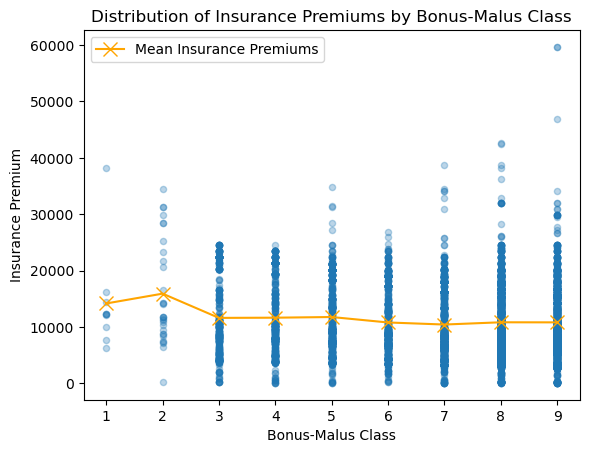

In [14]:
df.plot.scatter(x = "Bonus-Malus Class", y = "Insurance Premium", alpha = 0.3, zorder = 0)
plt.plot(q3.index, q3["mean_insurance_premium"], c = "orange", marker = "x", zorder = 10, markersize = 10, label = "Mean Insurance Premiums")
plt.legend(loc = "upper left")
plt.title("Distribution of Insurance Premiums by Bonus-Malus Class")
plt.show()

## 5. Given any 5 cities of your choice, which is the most popular vehicle manufacturing company in these cities?

The 5 most frequently occuring cities in this data set are chosen for analysis. Namely, they are **Aktobe**, **Almaty**, **Atbasar**, **Nur-Sultan** and **Petropavlovsk**. 
<br><br>
For **Aktobe**, **Almaty** and **Nur-Sultan**, **Toyota** is the most popular vehicle manufacturing company. For **Atbasar**, the most popular vehicle manufacturing company is **VAZ** while for **Petropavlovsk**, the most popular vehicle manufacturing company is **Volkswagen**.
<br><br>
Popularity of a vehicle manufacturing company is determined by the frequency the company brand is recorded in the data set.

In [15]:
top_5_cities = df["City"].value_counts().head(5).index

(df.loc[df["City"].isin(top_5_cities), ["City", "Brand"]]
     .value_counts()
     .reset_index()
     .groupby("City")
     .first()
     .rename(columns = {0: "Count Of Vehicles"})
)

,Brand,Count Of Vehicles
City,,
Aktobe,Toyota,141
Almaty,Toyota,1233
Atbasar,VAZ,124
Nur-Sultan,Toyota,264
Petropavlovsk,Volkswagen,101


## 6. What vehicle colors do people prefer more, light or dark? Group all colors to dark and light as you deem fit. 

In this data set, more vehicles are dark-colored. There are **7183 dark-colored vehicles** and **3702 light-colored vehicles**. The number of dark-colored vehicles is nearly twice that of light-colored ones. People seem to prefer dark-colored vehicles.

In [16]:
(df.groupby("Color Group")
     .size()
     .reset_index()
     .rename(columns = {0: "Number Of Vehicles"})
)

,Color Group,Number Of Vehicles
0,Dark,7183
1,Light,3702


## 7. Which is the most popular vehicle manufacturing company among females in Almaty, Shymkent and Nur-Saltan (Astana) respectively?

In Almaty and Nur-Sultan, the most most popular vehicle manufacturing brand among females is **Toyota** with 305 and 58 Toyota-produced vehicles respectively. In Shymkent, there is a tie between the most popular vehicle manufacturing brand among females. In fact, the data set only contains 3 females whose City is Shymkent, and all three use a different brand of vehicle. All 3 brands, **Mercedes-Benz**, **Audi** and **Toyota** have been included in the data frame below.

In [17]:
all_value_counts = (
    df.loc[(df["City"].isin(["Almaty", "Shymkent", "Nur-Sultan"])) & (df["Gender"] == "Female"), ["City", "Brand"]]
    .value_counts(["City", "Brand"])
    .reset_index()
    .rename(columns = {0: "Count Of Vehicles"})
)

q7 = (
    all_value_counts.groupby("City")["Count Of Vehicles"]
    .nlargest(n = 1, keep = "all")
    .reset_index()
    .assign(level_1 = lambda dataframe: all_value_counts.loc[dataframe["level_1"], "Brand"].values)
    .rename(columns = {"level_1": "Brand"})
)
q7 = q7.set_index("City")
q7.index = np.where(q7.index.duplicated(), "", q7.index)
q7.index.names = ["City"]
q7

,Brand,Count Of Vehicles
City,,
Almaty,Toyota,305
Nur-Sultan,Toyota,58
Shymkent,Mercedes-Benz,1
,Audi,1
,Toyota,1


## 8. What is the distribution of car road accidents in the various cities? Which city is first in place for road accidents? Are there any countryside areas among the top 10 cities with the most road accidents?

The number of road accidents involving cars aggregated by city is shown below. This distribution is similar to the distribution of general road accidents by city. 
<br><br>
In terms of general road accidents, **Almaty** with a frequency count of 55 road accidents is ranked first. The top 10 cities with the most road accidents are **Almaty**, **Petropavlosk**, **Nur-Sultan**, **Aktobe**, **Kostanay**, **Kokshetau**, **Atbasar**, **Karaganda**, **Shymkent** and **Pavlodar** *(in order of rank)*. 
<br><br>
All of these areas are rather developed and urban. They are mostly cities. However, unlike the rest of the top 10 regions, **Atbasar** is a small town, and is closest to the rural countryside. 

In [18]:
(df[(df["Vehicle Type"] == "Cars") & (df["Accident Status"] == "Accident")]
     .groupby("City")
     .size()
     .sort_values(ascending = False)
     .reset_index()
     .rename(columns = {0: "Number Of Car Accidents"})
)

,City,Number Of Car Accidents
0,Almaty,53
1,Petropavlovsk,17
2,Nur-Sultan,15
3,Aktobe,14
4,Kostanay,10
5,Kokshetau,5
6,Atbasar,4
7,Karaganda,3
8,Shymkent,2
9,Pavlodar,1


In [19]:
(df[df["Accident Status"] == "Accident"]
     .groupby("City")
     .size()
     .sort_values(ascending = False)
     .head(10)
     .reset_index()
     .rename(columns = {0: "Number Of Road Accidents"})
)

,City,Number Of Road Accidents
0,Almaty,55
1,Petropavlovsk,17
2,Nur-Sultan,15
3,Aktobe,15
4,Kostanay,10
5,Kokshetau,5
6,Atbasar,4
7,Karaganda,3
8,Shymkent,2
9,Pavlodar,1


## 9. How many people had more than 1 vehicle? Is there any driver who had more than 1 accident in a year?

**973** drivers had more than 1 vehicle. Only 1 driver had more than 1 accident in a year — the driver with `Unique Number` **1bbce6dfdba970d99f41ed1f44488fc8**.

In [20]:
(df.groupby("Unique Number")
     .size()
     .reset_index()
     .rename(columns = {0: "Number Of Vehicles"})
     .query('`Number Of Vehicles` > 1')
)

,Unique Number,Number Of Vehicles
23,00ce5edb26bc950bb6b8bc2542f228f3,2
32,010a949dc5eccda1e309fe0954ed94f1,2
64,01d831ff617e0f0e77bd237bf1b9bed1,2
67,01e8782cf57e847baa387fe76d893eb7,2
87,02dcee04506770b1909c0fa1ebe404e5,2
...,...,...
9378,fed1ab1df8de1cc68bf2ccaf918ac4e4,2
9381,fedaa7440589bfc670b4f36dcaaa6586,2
9406,ff8ad431598eea94fddeb8eab25283d3,3
9409,ffb765b2720e669c12b0e1e95bca8d4a,4


In [21]:
drivers_multiple_accidents = (
    df[df["Accident Status"] == "Accident"]
    .groupby("Unique Number")
    .size()
    .reset_index()
    .rename(columns = {0: "Number Of Accidents"})
    .query('`Number Of Accidents` > 1')["Unique Number"]
    .values
)

multiple_accidents = (
    df.loc[(df["Accident Status"] == "Accident") & (df["Unique Number"].isin(drivers_multiple_accidents)), ["Unique Number", "Date Of Incident"]]
    .sort_values(["Unique Number", "Date Of Incident"])
)

multiple_accidents["Next Date Of Incident"] = multiple_accidents.groupby("Unique Number")["Date Of Incident"].shift(-1).dropna()
multiple_accidents["Next Accident Within A Year"] = np.where(multiple_accidents["Next Date Of Incident"] == multiple_accidents["Date Of Incident"], 
                                                             False, 
                                                             np.where(multiple_accidents["Next Date Of Incident"] - multiple_accidents["Date Of Incident"] < datetime.timedelta(days = 365.35), 
                                                                      True, 
                                                                      False))

(multiple_accidents.groupby("Unique Number")["Next Accident Within A Year"]
     .any()
     .reset_index()
     .query('`Next Accident Within A Year` == True')
)

,Unique Number,Next Accident Within A Year
1,1bbce6dfdba970d99f41ed1f44488fc8,True


## 10. What is the distribution of road accidents by Bonus-Malus Class?

The distribution of road accidents by Bonus-Malus Class is shown in the table below. 

- Bonus-Malus Classes **1 and 2** have **low** number of road accidents. 
- Classes **3 to 7** have a **moderate** number of road accidents. 
- Classes **8 and 9** have a **high** number of road accidents.

In [22]:
q10 = (
    df.groupby("Bonus-Malus Class")["Accident Indicator"]
    .sum()
    .reset_index()
    .rename(columns = {"Accident Indicator": "Number Of Road Accidents"})
)

q10

,Bonus-Malus Class,Number Of Road Accidents
0,1,0
1,2,2
2,3,18
3,4,8
4,5,16
5,6,12
6,7,12
7,8,38
8,9,29


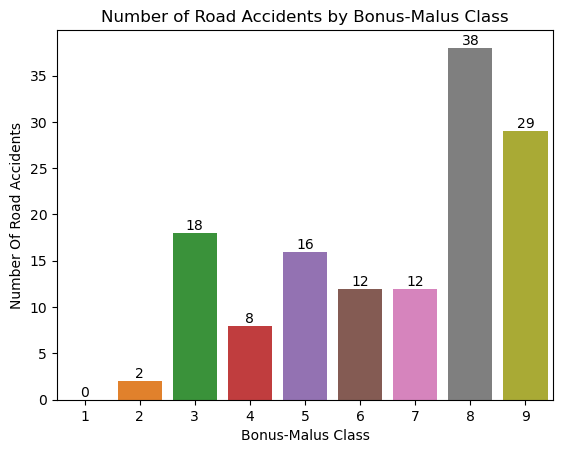

In [23]:
ax = sns.barplot(data = q10, x = "Bonus-Malus Class", y = "Number Of Road Accidents", errorbar = None)
ax.bar_label(ax.containers[0])
plt.title("Number of Road Accidents by Bonus-Malus Class")
plt.show()